# Clifford Algebras: A Computational Introduction

## 1. Theoretical Foundation

### 1.1 Definition and Motivation

**Clifford algebras** (also known as **geometric algebras**) are associative algebras that generalize the real numbers, complex numbers, quaternions, and exterior algebras. They provide a unified framework for describing rotations, reflections, and geometric transformations in spaces of arbitrary dimension.

Given a vector space $V$ over a field $\mathbb{K}$ with a quadratic form $Q: V \to \mathbb{K}$, the **Clifford algebra** $\text{Cl}(V, Q)$ is the quotient of the tensor algebra $T(V)$ by the two-sided ideal generated by elements of the form:

$$v \otimes v - Q(v) \cdot 1$$

for all $v \in V$. This means that in the Clifford algebra, we have the fundamental relation:

$$v^2 = Q(v)$$

### 1.2 The Clifford Product

For an orthonormal basis $\{e_1, e_2, \ldots, e_n\}$ of $V$ with signature $(p, q)$ (meaning $p$ basis vectors square to $+1$ and $q$ square to $-1$), the **Clifford product** satisfies:

$$e_i e_j + e_j e_i = 2 \eta_{ij}$$

where $\eta_{ij}$ is the metric tensor (diagonal with entries $\pm 1$). For $i \neq j$:

$$e_i e_j = -e_j e_i$$

This anticommutation for distinct basis vectors is a defining characteristic.

### 1.3 Basis and Dimension

The Clifford algebra $\text{Cl}_{p,q}$ has dimension $2^n$ where $n = p + q$. A basis consists of:

$$\{1, e_1, e_2, \ldots, e_n, e_1 e_2, e_1 e_3, \ldots, e_1 e_2 \cdots e_n\}$$

These are called **blades** or **multivectors** of various grades:
- Grade 0: Scalars (1 element)
- Grade 1: Vectors ($n$ elements)
- Grade 2: Bivectors ($\binom{n}{2}$ elements)
- Grade $k$: $k$-vectors ($\binom{n}{k}$ elements)

### 1.4 Important Examples

| Algebra | Signature | Isomorphic to |
|---------|-----------|---------------|
| $\text{Cl}_{0,0}$ | $(0,0)$ | $\mathbb{R}$ |
| $\text{Cl}_{0,1}$ | $(0,1)$ | $\mathbb{C}$ |
| $\text{Cl}_{0,2}$ | $(0,2)$ | $\mathbb{H}$ (quaternions) |
| $\text{Cl}_{3,0}$ | $(3,0)$ | Pauli algebra |
| $\text{Cl}_{1,3}$ | $(1,3)$ | Spacetime algebra |

### 1.5 Geometric Product Decomposition

For vectors $u, v \in V$, the geometric (Clifford) product decomposes as:

$$uv = u \cdot v + u \wedge v$$

where:
- $u \cdot v = \frac{1}{2}(uv + vu)$ is the **inner product** (symmetric part, scalar)
- $u \wedge v = \frac{1}{2}(uv - vu)$ is the **outer/wedge product** (antisymmetric part, bivector)

## 2. Implementation of Clifford Algebra $\text{Cl}_{3,0}$

We will implement the Clifford algebra $\text{Cl}_{3,0}$ (3D Euclidean space) from scratch. This algebra has $2^3 = 8$ basis elements:

$$\{1, e_1, e_2, e_3, e_{12}, e_{13}, e_{23}, e_{123}\}$$

where $e_{ij} = e_i e_j$ and $e_{123} = e_1 e_2 e_3$ (the pseudoscalar).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

class CliffordAlgebra:
    """
    Implementation of Clifford Algebra Cl(p,q) for arbitrary signatures.
    
    Multivectors are represented as dictionaries mapping basis blade tuples
    to their coefficients.
    """
    
    def __init__(self, p, q=0):
        """
        Initialize Clifford algebra Cl(p,q).
        
        Parameters:
        -----------
        p : int
            Number of basis vectors squaring to +1
        q : int
            Number of basis vectors squaring to -1
        """
        self.p = p
        self.q = q
        self.n = p + q
        self.dim = 2 ** self.n
        
        # Metric signature: first p are +1, next q are -1
        self.metric = np.array([1]*p + [-1]*q)
        
        # Generate all basis blades
        self.basis_blades = [()]
        for k in range(1, self.n + 1):
            self.basis_blades.extend(combinations(range(self.n), k))
        self.basis_blades = [tuple(b) for b in self.basis_blades]
    
    def blade_product(self, blade1, blade2):
        """
        Compute the Clifford product of two basis blades.
        
        Returns (sign, result_blade) where result_blade is a sorted tuple.
        """
        # Concatenate blades
        combined = list(blade1) + list(blade2)
        
        # Bubble sort to canonical order, tracking sign from swaps
        sign = 1
        result = combined.copy()
        
        # Bubble sort with swap counting
        for i in range(len(result)):
            for j in range(len(result) - 1, i, -1):
                if result[j-1] > result[j]:
                    result[j-1], result[j] = result[j], result[j-1]
                    sign *= -1  # Anticommutation
        
        # Cancel pairs (e_i * e_i = metric[i])
        final_result = []
        i = 0
        while i < len(result):
            if i + 1 < len(result) and result[i] == result[i+1]:
                # e_i^2 = metric[i]
                sign *= self.metric[result[i]]
                i += 2
            else:
                final_result.append(result[i])
                i += 1
        
        return sign, tuple(final_result)
    
    def multivector(self, coeffs=None):
        """
        Create a multivector from coefficients.
        
        Parameters:
        -----------
        coeffs : dict or None
            Dictionary mapping basis blade tuples to coefficients.
            Example: {(): 1, (0,): 2, (0,1): 3} represents 1 + 2*e1 + 3*e12
        """
        return Multivector(self, coeffs if coeffs else {})
    
    def scalar(self, value):
        """Create a scalar multivector."""
        return self.multivector({(): value})
    
    def vector(self, components):
        """Create a grade-1 vector from components."""
        coeffs = {(i,): components[i] for i in range(len(components)) if components[i] != 0}
        return self.multivector(coeffs)
    
    def basis_vector(self, i):
        """Return the i-th basis vector e_i."""
        return self.multivector({(i,): 1})


class Multivector:
    """A multivector in a Clifford algebra."""
    
    def __init__(self, algebra, coeffs):
        self.algebra = algebra
        # Remove zero coefficients
        self.coeffs = {k: v for k, v in coeffs.items() if abs(v) > 1e-15}
    
    def __repr__(self):
        if not self.coeffs:
            return "0"
        
        terms = []
        for blade in sorted(self.coeffs.keys(), key=lambda x: (len(x), x)):
            coeff = self.coeffs[blade]
            if blade == ():
                terms.append(f"{coeff:.4g}")
            else:
                blade_str = "e" + "".join(str(i+1) for i in blade)
                if coeff == 1:
                    terms.append(blade_str)
                elif coeff == -1:
                    terms.append(f"-{blade_str}")
                else:
                    terms.append(f"{coeff:.4g}*{blade_str}")
        
        result = terms[0]
        for term in terms[1:]:
            if term.startswith("-"):
                result += f" {term}"
            else:
                result += f" + {term}"
        return result
    
    def __add__(self, other):
        if isinstance(other, (int, float)):
            other = self.algebra.scalar(other)
        new_coeffs = self.coeffs.copy()
        for blade, coeff in other.coeffs.items():
            new_coeffs[blade] = new_coeffs.get(blade, 0) + coeff
        return Multivector(self.algebra, new_coeffs)
    
    def __radd__(self, other):
        return self.__add__(other)
    
    def __sub__(self, other):
        return self + (-1 * other)
    
    def __mul__(self, other):
        """Clifford (geometric) product."""
        if isinstance(other, (int, float)):
            return Multivector(self.algebra, {k: v * other for k, v in self.coeffs.items()})
        
        new_coeffs = {}
        for blade1, coeff1 in self.coeffs.items():
            for blade2, coeff2 in other.coeffs.items():
                sign, result_blade = self.algebra.blade_product(blade1, blade2)
                new_coeffs[result_blade] = new_coeffs.get(result_blade, 0) + sign * coeff1 * coeff2
        
        return Multivector(self.algebra, new_coeffs)
    
    def __rmul__(self, other):
        if isinstance(other, (int, float)):
            return self.__mul__(other)
        return NotImplemented
    
    def __neg__(self):
        return -1 * self
    
    def grade(self, k):
        """Extract the grade-k part of the multivector."""
        new_coeffs = {blade: coeff for blade, coeff in self.coeffs.items() if len(blade) == k}
        return Multivector(self.algebra, new_coeffs)
    
    def scalar_part(self):
        """Return the scalar (grade-0) part."""
        return self.coeffs.get((), 0)
    
    def reverse(self):
        """Compute the reverse (reversion) of the multivector."""
        new_coeffs = {}
        for blade, coeff in self.coeffs.items():
            k = len(blade)
            # Reverse sign: (-1)^(k(k-1)/2)
            sign = (-1) ** (k * (k - 1) // 2)
            new_coeffs[blade] = sign * coeff
        return Multivector(self.algebra, new_coeffs)
    
    def norm_squared(self):
        """Compute the norm squared: <M * M~>_0"""
        return (self * self.reverse()).scalar_part()
    
    def norm(self):
        """Compute the norm."""
        ns = self.norm_squared()
        return np.sqrt(abs(ns))
    
    def inverse(self):
        """Compute the inverse (for invertible elements)."""
        rev = self.reverse()
        ns = (self * rev).scalar_part()
        if abs(ns) < 1e-15:
            raise ValueError("Multivector is not invertible")
        return (1/ns) * rev


def inner_product(a, b):
    """Compute the inner (dot) product of two multivectors."""
    return 0.5 * (a * b + b * a)


def outer_product(a, b):
    """Compute the outer (wedge) product of two multivectors."""
    return 0.5 * (a * b - b * a)


print("Clifford Algebra implementation loaded successfully!")

Clifford Algebra implementation loaded successfully!


## 3. Verification of Algebra Properties

Let us verify the fundamental properties of $\text{Cl}_{3,0}$.

In [2]:
# Create Cl(3,0) - 3D Euclidean Clifford algebra
cl3 = CliffordAlgebra(3, 0)

# Get basis vectors
e1 = cl3.basis_vector(0)
e2 = cl3.basis_vector(1)
e3 = cl3.basis_vector(2)

print("Basis vectors:")
print(f"e1 = {e1}")
print(f"e2 = {e2}")
print(f"e3 = {e3}")

print("\n" + "="*50)
print("Verifying e_i^2 = 1 (Euclidean signature):")
print("="*50)
print(f"e1 * e1 = {e1 * e1}")
print(f"e2 * e2 = {e2 * e2}")
print(f"e3 * e3 = {e3 * e3}")

print("\n" + "="*50)
print("Verifying anticommutation e_i * e_j = -e_j * e_i:")
print("="*50)
print(f"e1 * e2 = {e1 * e2}")
print(f"e2 * e1 = {e2 * e1}")
print(f"e1 * e2 + e2 * e1 = {e1 * e2 + e2 * e1}")

print("\n" + "="*50)
print("Bivectors (grade-2 elements):")
print("="*50)
e12 = e1 * e2
e13 = e1 * e3
e23 = e2 * e3
print(f"e12 = e1*e2 = {e12}")
print(f"e13 = e1*e3 = {e13}")
print(f"e23 = e2*e3 = {e23}")

print("\n" + "="*50)
print("Bivector squares (should be -1 for Euclidean):")
print("="*50)
print(f"e12^2 = {e12 * e12}")
print(f"e13^2 = {e13 * e13}")
print(f"e23^2 = {e23 * e23}")

print("\n" + "="*50)
print("Pseudoscalar (volume element):")
print("="*50)
e123 = e1 * e2 * e3
print(f"e123 = e1*e2*e3 = {e123}")
print(f"e123^2 = {e123 * e123}")

Basis vectors:
e1 = e1
e2 = e2
e3 = e3

Verifying e_i^2 = 1 (Euclidean signature):
e1 * e1 = 1
e2 * e2 = 1
e3 * e3 = 1

Verifying anticommutation e_i * e_j = -e_j * e_i:
e1 * e2 = e12
e2 * e1 = -e12
e1 * e2 + e2 * e1 = 0

Bivectors (grade-2 elements):
e12 = e1*e2 = e12
e13 = e1*e3 = e13
e23 = e2*e3 = e23

Bivector squares (should be -1 for Euclidean):
e12^2 = -1
e13^2 = -1
e23^2 = -1

Pseudoscalar (volume element):
e123 = e1*e2*e3 = e123
e123^2 = -1


## 4. Geometric Operations

### 4.1 Reflections

A reflection of vector $v$ through a hyperplane perpendicular to unit vector $n$ is given by:

$$v' = -n v n$$

### 4.2 Rotations

A rotation in the plane defined by bivector $B = u \wedge v$ through angle $\theta$ is achieved using the **rotor**:

$$R = e^{-B\theta/2} = \cos(\theta/2) - B\sin(\theta/2)$$

The rotation of a vector $v$ is:

$$v' = R v R^\dagger$$

where $R^\dagger$ is the reverse of $R$.

In [3]:
def reflect(v, n):
    """
    Reflect vector v through hyperplane perpendicular to n.
    Formula: v' = -n * v * n
    """
    return -1 * (n * v * n)


def rotor(bivector, angle):
    """
    Create a rotor for rotation in the plane defined by bivector.
    R = cos(θ/2) - B*sin(θ/2) where B is a unit bivector.
    """
    algebra = bivector.algebra
    half_angle = angle / 2
    # Normalize the bivector
    b_norm = bivector.norm()
    if b_norm > 1e-15:
        unit_b = (1/b_norm) * bivector
    else:
        unit_b = bivector
    
    return algebra.scalar(np.cos(half_angle)) - np.sin(half_angle) * unit_b


def rotate(v, R):
    """
    Rotate vector v using rotor R.
    Formula: v' = R * v * R†
    """
    return R * v * R.reverse()


# Example: Reflect e1 through the plane perpendicular to e2
print("="*50)
print("Reflection Example")
print("="*50)
v = e1
n = e2
v_reflected = reflect(v, n)
print(f"Original vector: {v}")
print(f"Normal to plane: {n}")
print(f"Reflected vector: {v_reflected}")

# Example: Rotate e1 by 90 degrees in the e1-e2 plane
print("\n" + "="*50)
print("Rotation Example: 90° in e1-e2 plane")
print("="*50)
R = rotor(e12, np.pi/2)  # 90 degree rotation
print(f"Rotor R = {R}")
print(f"R * R† = {R * R.reverse()}")

v_rotated = rotate(e1, R)
print(f"\nOriginal: e1 = {e1}")
print(f"Rotated by 90°: {v_rotated}")

# Rotate e2 by 90 degrees
v2_rotated = rotate(e2, R)
print(f"\nOriginal: e2 = {e2}")
print(f"Rotated by 90°: {v2_rotated}")

# General vector rotation
print("\n" + "="*50)
print("General Vector Rotation")
print("="*50)
v = cl3.vector([1, 1, 0])  # 45° in x-y plane
print(f"Original vector: {v}")
for angle_deg in [30, 45, 60, 90, 180]:
    angle_rad = np.deg2rad(angle_deg)
    R = rotor(e12, angle_rad)
    v_rot = rotate(v, R)
    print(f"After {angle_deg}° rotation: {v_rot}")

Reflection Example
Original vector: e1
Normal to plane: e2
Reflected vector: e1

Rotation Example: 90° in e1-e2 plane
Rotor R = 0.7071 -0.7071*e12
R * R† = 1

Original: e1 = e1
Rotated by 90°: e2

Original: e2 = e2
Rotated by 90°: -e1

General Vector Rotation
Original vector: e1 + e2
After 30° rotation: 0.366*e1 + 1.366*e2
After 45° rotation: 1.414*e2
After 60° rotation: -0.366*e1 + 1.366*e2
After 90° rotation: -1*e1 + e2
After 180° rotation: -e1 -e2


## 5. Connection to Complex Numbers and Quaternions

### 5.1 Complex Numbers as $\text{Cl}_{0,1}$

In $\text{Cl}_{0,1}$, we have a single basis vector $e_1$ with $e_1^2 = -1$. This is exactly the imaginary unit $i$!

A general element is $z = a + b e_1 \cong a + bi$.

### 5.2 Quaternions as $\text{Cl}_{0,2}$

In $\text{Cl}_{0,2}$, we have $e_1^2 = e_2^2 = -1$ and $e_{12}^2 = -1$. The quaternion basis is:
- $1 \to 1$
- $i \to e_1$
- $j \to e_2$
- $k \to e_{12}$

In [4]:
# Complex numbers as Cl(0,1)
print("="*50)
print("Complex Numbers as Cl(0,1)")
print("="*50)

cl_complex = CliffordAlgebra(0, 1)
i = cl_complex.basis_vector(0)  # Imaginary unit

print(f"i = {i}")
print(f"i^2 = {i * i}")

# Complex multiplication: (a + bi)(c + di) = (ac - bd) + (ad + bc)i
z1 = cl_complex.scalar(3) + 4 * i  # 3 + 4i
z2 = cl_complex.scalar(1) + 2 * i  # 1 + 2i
print(f"\nz1 = {z1}")
print(f"z2 = {z2}")
print(f"z1 * z2 = {z1 * z2}")  # Should be (3-8) + (6+4)i = -5 + 10i

# Quaternions as Cl(0,2)
print("\n" + "="*50)
print("Quaternions as Cl(0,2)")
print("="*50)

cl_quat = CliffordAlgebra(0, 2)
qi = cl_quat.basis_vector(0)
qj = cl_quat.basis_vector(1)
qk = qi * qj

print(f"i = {qi}")
print(f"j = {qj}")
print(f"k = i*j = {qk}")

print(f"\ni^2 = {qi * qi}")
print(f"j^2 = {qj * qj}")
print(f"k^2 = {qk * qk}")
print(f"i*j*k = {qi * qj * qk}")

# Verify quaternion identities
print(f"\ni*j = {qi * qj}")
print(f"j*i = {qj * qi}")
print(f"j*k = {qj * qk}")
print(f"k*j = {qk * qj}")
print(f"k*i = {qk * qi}")
print(f"i*k = {qi * qk}")

Complex Numbers as Cl(0,1)
i = e1
i^2 = -1

z1 = 3 + 4*e1
z2 = 1 + 2*e1
z1 * z2 = -5 + 10*e1

Quaternions as Cl(0,2)
i = e1
j = e2
k = i*j = e12

i^2 = -1
j^2 = -1
k^2 = -1
i*j*k = -1

i*j = e12
j*i = -e12
j*k = e1
k*j = -e1
k*i = e2
i*k = -e2


## 6. Visualization: Rotations in 3D Using Rotors

We will visualize how rotors transform vectors in 3D space, showing the elegant geometry of Clifford algebra rotations.

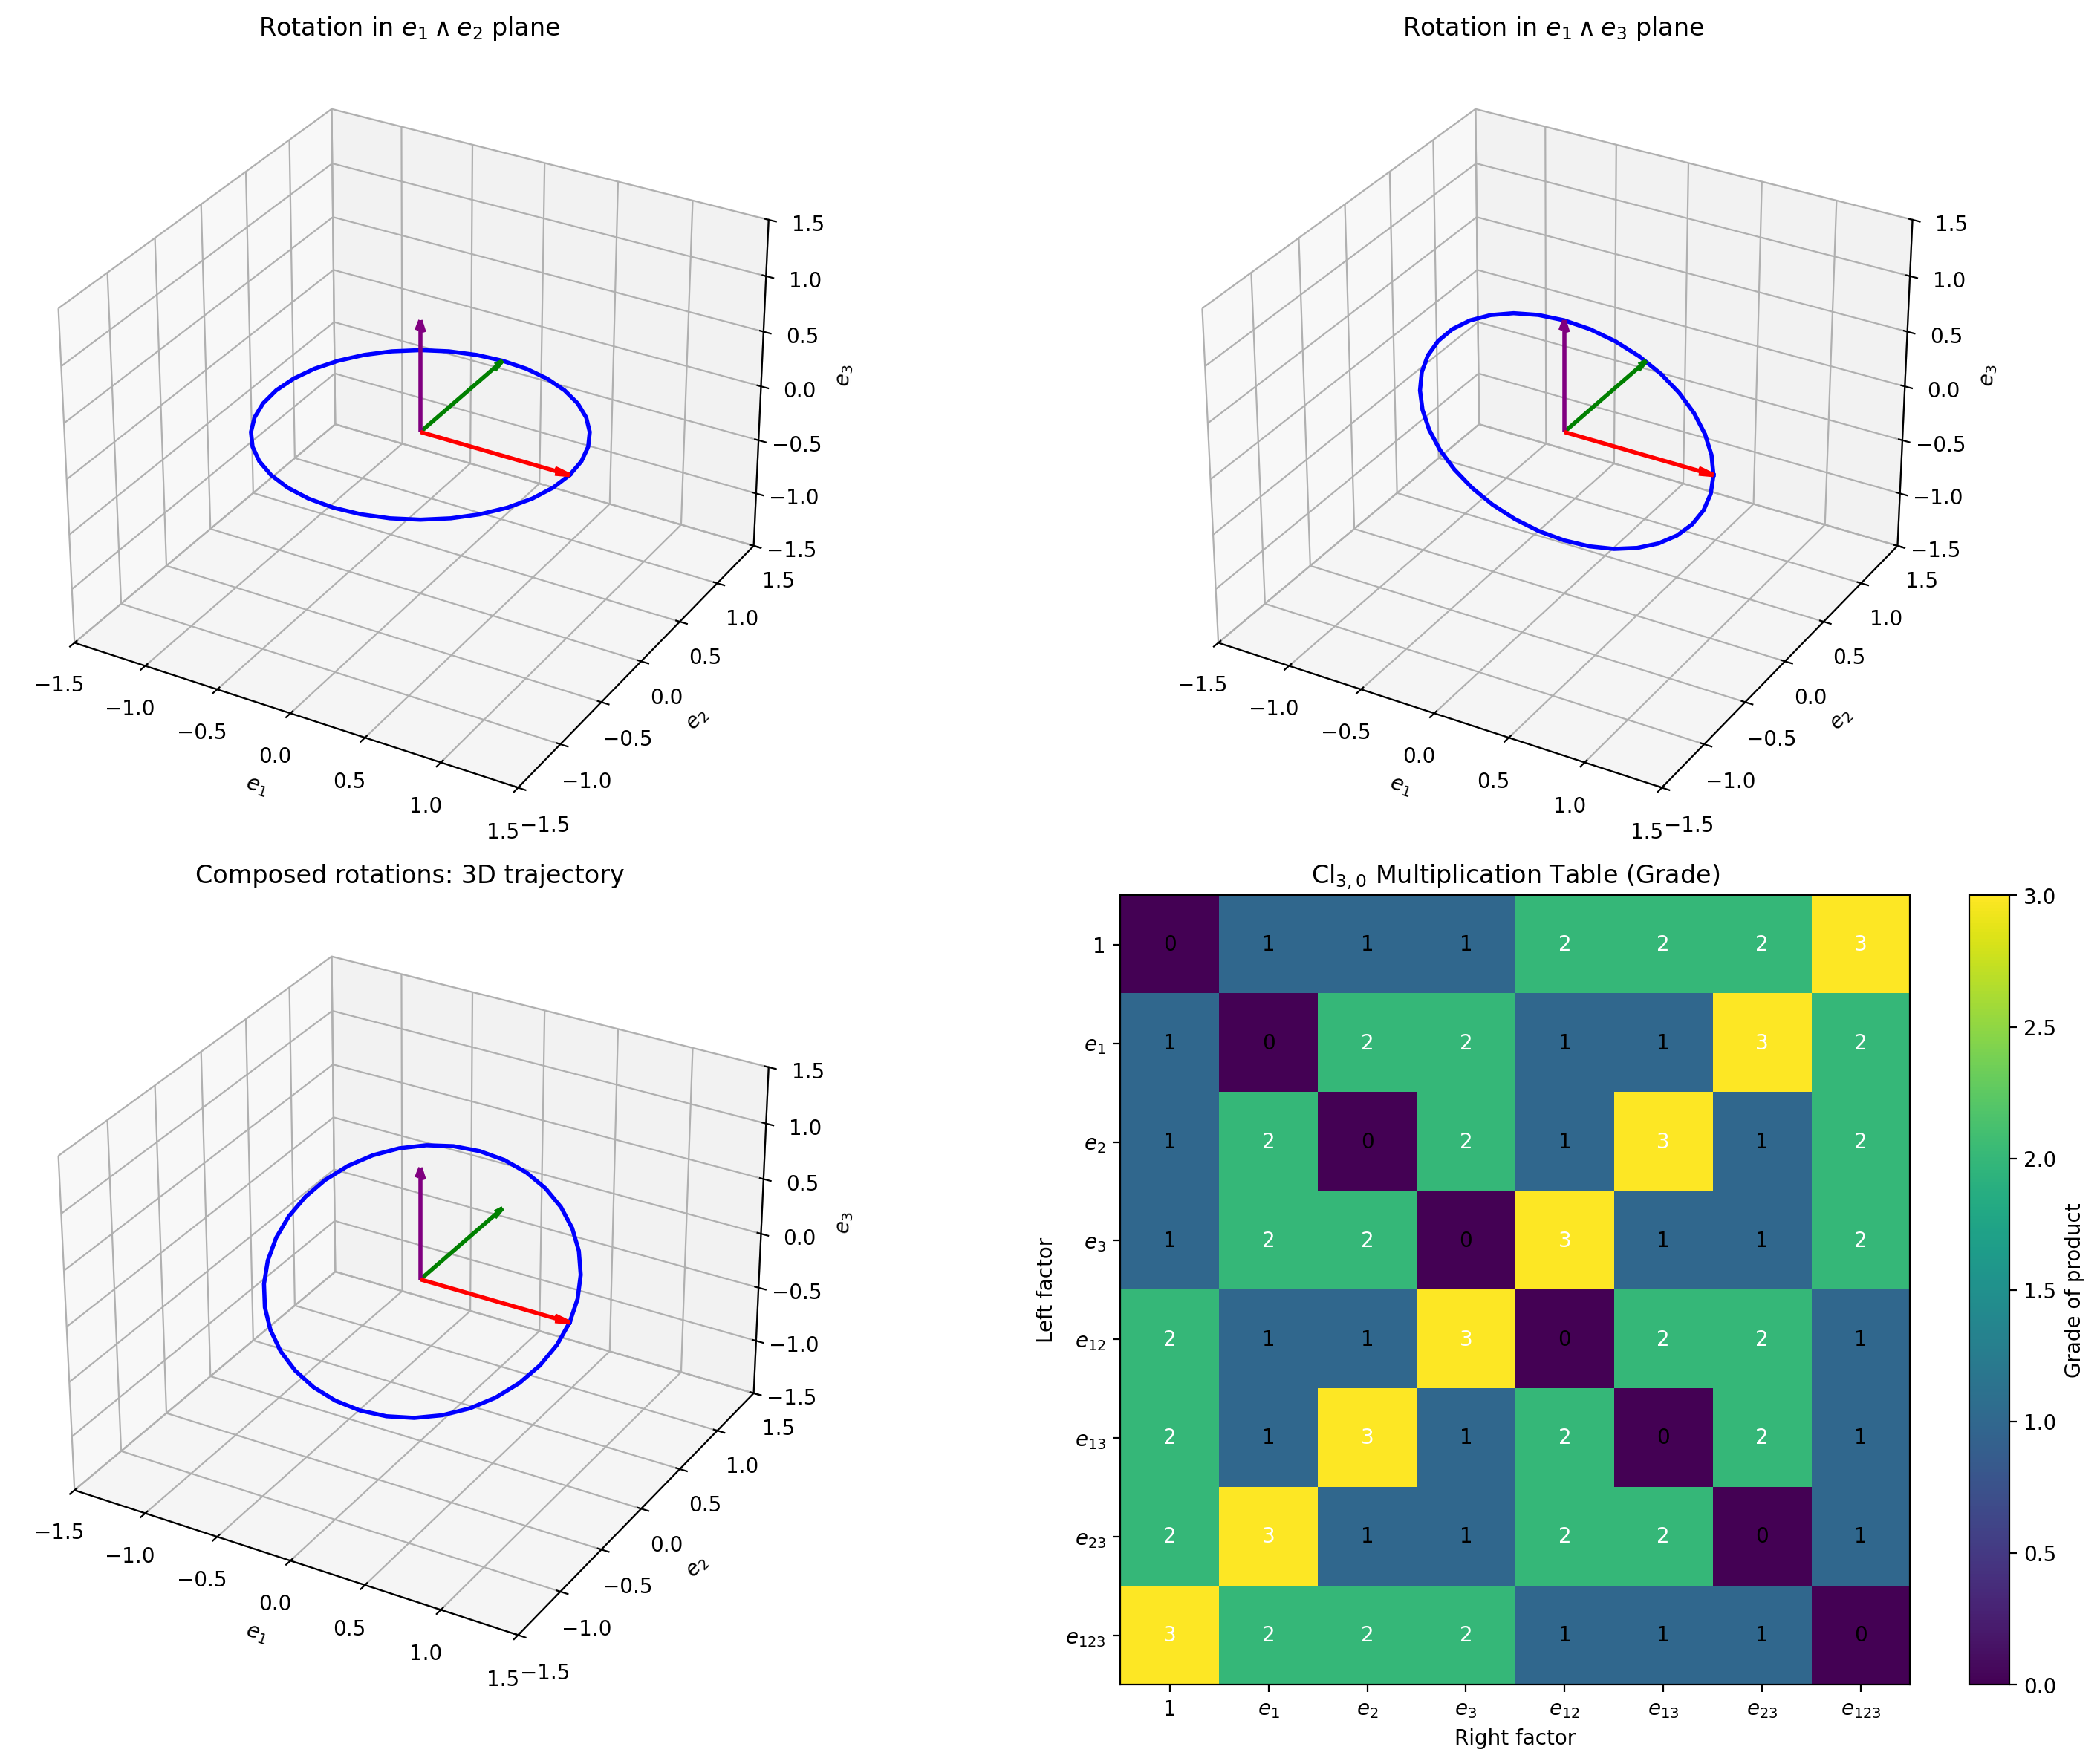


Visualization saved to 'plot.png'


In [5]:
def multivector_to_vector(mv):
    """Extract 3D vector components from a multivector."""
    x = mv.coeffs.get((0,), 0)
    y = mv.coeffs.get((1,), 0)
    z = mv.coeffs.get((2,), 0)
    return np.array([x, y, z])


# Create figure with multiple subplots
fig = plt.figure(figsize=(16, 12))

# Plot 1: Rotation in xy-plane
ax1 = fig.add_subplot(221, projection='3d')
ax1.set_title(r'Rotation in $e_1 \wedge e_2$ plane', fontsize=12)

# Initial vector
v0 = cl3.vector([1, 0, 0])
angles = np.linspace(0, 2*np.pi, 37)

trajectory = []
for angle in angles:
    R = rotor(e12, angle)
    v_rot = rotate(v0, R)
    trajectory.append(multivector_to_vector(v_rot))
trajectory = np.array(trajectory)

ax1.plot(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2], 'b-', linewidth=2, label='Trajectory')
ax1.quiver(0, 0, 0, 1, 0, 0, color='r', arrow_length_ratio=0.1, linewidth=2, label='Initial')
ax1.quiver(0, 0, 0, 0, 1, 0, color='g', arrow_length_ratio=0.1, linewidth=2)
ax1.quiver(0, 0, 0, 0, 0, 1, color='purple', arrow_length_ratio=0.1, linewidth=2)
ax1.set_xlabel('$e_1$')
ax1.set_ylabel('$e_2$')
ax1.set_zlabel('$e_3$')
ax1.set_xlim([-1.5, 1.5])
ax1.set_ylim([-1.5, 1.5])
ax1.set_zlim([-1.5, 1.5])

# Plot 2: Rotation in xz-plane
ax2 = fig.add_subplot(222, projection='3d')
ax2.set_title(r'Rotation in $e_1 \wedge e_3$ plane', fontsize=12)

trajectory2 = []
for angle in angles:
    R = rotor(e13, angle)
    v_rot = rotate(v0, R)
    trajectory2.append(multivector_to_vector(v_rot))
trajectory2 = np.array(trajectory2)

ax2.plot(trajectory2[:, 0], trajectory2[:, 1], trajectory2[:, 2], 'b-', linewidth=2)
ax2.quiver(0, 0, 0, 1, 0, 0, color='r', arrow_length_ratio=0.1, linewidth=2)
ax2.quiver(0, 0, 0, 0, 1, 0, color='g', arrow_length_ratio=0.1, linewidth=2)
ax2.quiver(0, 0, 0, 0, 0, 1, color='purple', arrow_length_ratio=0.1, linewidth=2)
ax2.set_xlabel('$e_1$')
ax2.set_ylabel('$e_2$')
ax2.set_zlabel('$e_3$')
ax2.set_xlim([-1.5, 1.5])
ax2.set_ylim([-1.5, 1.5])
ax2.set_zlim([-1.5, 1.5])

# Plot 3: Composition of rotations (3D rotation about arbitrary axis)
ax3 = fig.add_subplot(223, projection='3d')
ax3.set_title('Composed rotations: 3D trajectory', fontsize=12)

# Create a bivector for rotation about a diagonal axis
# Bivector n1 ∧ n2 defines the rotation plane
n1 = cl3.vector([1, 0, 0])
n2 = cl3.vector([0, 1, 1])
B = outer_product(n1, n2)

trajectory3 = []
for angle in angles:
    R = rotor(B, angle)
    v_rot = rotate(v0, R)
    trajectory3.append(multivector_to_vector(v_rot))
trajectory3 = np.array(trajectory3)

ax3.plot(trajectory3[:, 0], trajectory3[:, 1], trajectory3[:, 2], 'b-', linewidth=2)
ax3.quiver(0, 0, 0, 1, 0, 0, color='r', arrow_length_ratio=0.1, linewidth=2)
ax3.quiver(0, 0, 0, 0, 1, 0, color='g', arrow_length_ratio=0.1, linewidth=2)
ax3.quiver(0, 0, 0, 0, 0, 1, color='purple', arrow_length_ratio=0.1, linewidth=2)
ax3.set_xlabel('$e_1$')
ax3.set_ylabel('$e_2$')
ax3.set_zlabel('$e_3$')
ax3.set_xlim([-1.5, 1.5])
ax3.set_ylim([-1.5, 1.5])
ax3.set_zlim([-1.5, 1.5])

# Plot 4: Clifford algebra multiplication table visualization
ax4 = fig.add_subplot(224)
ax4.set_title(r'$\mathrm{Cl}_{3,0}$ Multiplication Table (Grade)', fontsize=12)

# Create multiplication table
basis_elements = [cl3.scalar(1), e1, e2, e3, e12, e13, e23, e123]
basis_labels = ['1', '$e_1$', '$e_2$', '$e_3$', '$e_{12}$', '$e_{13}$', '$e_{23}$', '$e_{123}$']

# Compute grades of products
grade_table = np.zeros((8, 8))
for i, bi in enumerate(basis_elements):
    for j, bj in enumerate(basis_elements):
        product = bi * bj
        # Find the grade of the result
        if product.coeffs:
            grade = len(list(product.coeffs.keys())[0])
        else:
            grade = 0
        grade_table[i, j] = grade

im = ax4.imshow(grade_table, cmap='viridis', vmin=0, vmax=3)
ax4.set_xticks(range(8))
ax4.set_yticks(range(8))
ax4.set_xticklabels(basis_labels)
ax4.set_yticklabels(basis_labels)
ax4.set_xlabel('Right factor')
ax4.set_ylabel('Left factor')

# Add colorbar
cbar = plt.colorbar(im, ax=ax4)
cbar.set_label('Grade of product')

# Add text annotations
for i in range(8):
    for j in range(8):
        ax4.text(j, i, int(grade_table[i, j]), ha='center', va='center', 
                 color='white' if grade_table[i, j] > 1.5 else 'black', fontsize=10)

plt.tight_layout()
plt.savefig('clifford_algebras_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nVisualization saved to 'plot.png'")

## 7. The Spacetime Algebra $\text{Cl}_{1,3}$

The **spacetime algebra** (STA) is $\text{Cl}_{1,3}$ with signature $(+,-,-,-)$. It provides a coordinate-free formulation of special relativity.

The basis vectors satisfy:
- $\gamma_0^2 = +1$ (timelike)
- $\gamma_i^2 = -1$ for $i = 1, 2, 3$ (spacelike)

The pseudoscalar $I = \gamma_0 \gamma_1 \gamma_2 \gamma_3$ satisfies $I^2 = -1$.

In [6]:
# Spacetime Algebra Cl(1,3)
print("="*50)
print("Spacetime Algebra Cl(1,3)")
print("="*50)

sta = CliffordAlgebra(1, 3)

gamma0 = sta.basis_vector(0)  # Timelike
gamma1 = sta.basis_vector(1)  # Spacelike
gamma2 = sta.basis_vector(2)  # Spacelike
gamma3 = sta.basis_vector(3)  # Spacelike

print(f"Dimension of Cl(1,3): {sta.dim}")
print(f"\nBasis vector squares:")
print(f"γ₀² = {gamma0 * gamma0} (timelike, +1)")
print(f"γ₁² = {gamma1 * gamma1} (spacelike, -1)")
print(f"γ₂² = {gamma2 * gamma2} (spacelike, -1)")
print(f"γ₃² = {gamma3 * gamma3} (spacelike, -1)")

# Pseudoscalar
I = gamma0 * gamma1 * gamma2 * gamma3
print(f"\nPseudoscalar I = γ₀γ₁γ₂γ₃")
print(f"I² = {I * I}")

# Spatial subalgebra (relative vectors)
print(f"\nRelative vectors (σᵢ = γᵢγ₀):")
sigma1 = gamma1 * gamma0
sigma2 = gamma2 * gamma0
sigma3 = gamma3 * gamma0
print(f"σ₁² = {sigma1 * sigma1}")
print(f"σ₂² = {sigma2 * sigma2}")
print(f"σ₃² = {sigma3 * sigma3}")
print(f"\nThese form the Pauli algebra (spatial rotations)!")

Spacetime Algebra Cl(1,3)
Dimension of Cl(1,3): 16

Basis vector squares:
γ₀² = 1 (timelike, +1)
γ₁² = -1 (spacelike, -1)
γ₂² = -1 (spacelike, -1)
γ₃² = -1 (spacelike, -1)

Pseudoscalar I = γ₀γ₁γ₂γ₃
I² = -1

Relative vectors (σᵢ = γᵢγ₀):
σ₁² = 1
σ₂² = 1
σ₃² = 1

These form the Pauli algebra (spatial rotations)!


## 8. Summary and Applications

### Key Results

1. **Clifford algebras** unify scalars, vectors, bivectors, and higher-grade elements into a single algebraic framework.

2. **The geometric product** $uv = u \cdot v + u \wedge v$ naturally combines inner and outer products.

3. **Rotors** $R = e^{-B\theta/2}$ provide a double-cover of rotations, elegantly handling 3D and higher-dimensional rotations.

4. **Complex numbers** ($\text{Cl}_{0,1}$) and **quaternions** ($\text{Cl}_{0,2}$) are special cases.

5. The **spacetime algebra** ($\text{Cl}_{1,3}$) provides a coordinate-free framework for relativistic physics.

### Applications

- **Computer graphics**: Efficient rotation representations
- **Robotics**: Kinematics and dynamics
- **Physics**: Electromagnetism, quantum mechanics, general relativity
- **Signal processing**: Geometric Fourier transforms
- **Machine learning**: Geometric deep learning

### References

1. Hestenes, D. (1984). *Clifford Algebra to Geometric Calculus*
2. Doran, C. & Lasenby, A. (2003). *Geometric Algebra for Physicists*
3. Dorst, L. et al. (2007). *Geometric Algebra for Computer Science*